<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Нам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Построим модель с предельно большим значением *F1*-меры.  Модель будет считаться успешной, если метрика F1 для неё составит не менее 0.59

Дополнительно будем измерять *AUC-ROC и сравнивать её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

# Описание данных

# Признаки

* RowNumber — индекс строки в данных
* CustomerId — уникальный идентификатор клиента
* Surname — фамилия
* CreditScore — кредитный рейтинг
* Geography — страна проживания
* Gender — пол
* Age — возраст
* Tenure — сколько лет человек является клиентом банка
* Balance — баланс на счёте
* NumOfProducts — количество продуктов банка, используемых клиентом
* HasCrCard — наличие кредитной карты
* IsActiveMember — активность клиента
* EstimatedSalary — предполагаемая зарплата

# Целевой признак

* Exited — факт ухода клиента

## Подготовка данных

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from joblib import dump
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve 
import seaborn as sns
data = pd.read_csv('/content/6_churn.csv')

In [ ]:
data.head() #выведем первые 5 строк датафрейма на экран

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Проверим данные на предмет наличия мультиколлениарности при помощи метода, `sns.pairplot`

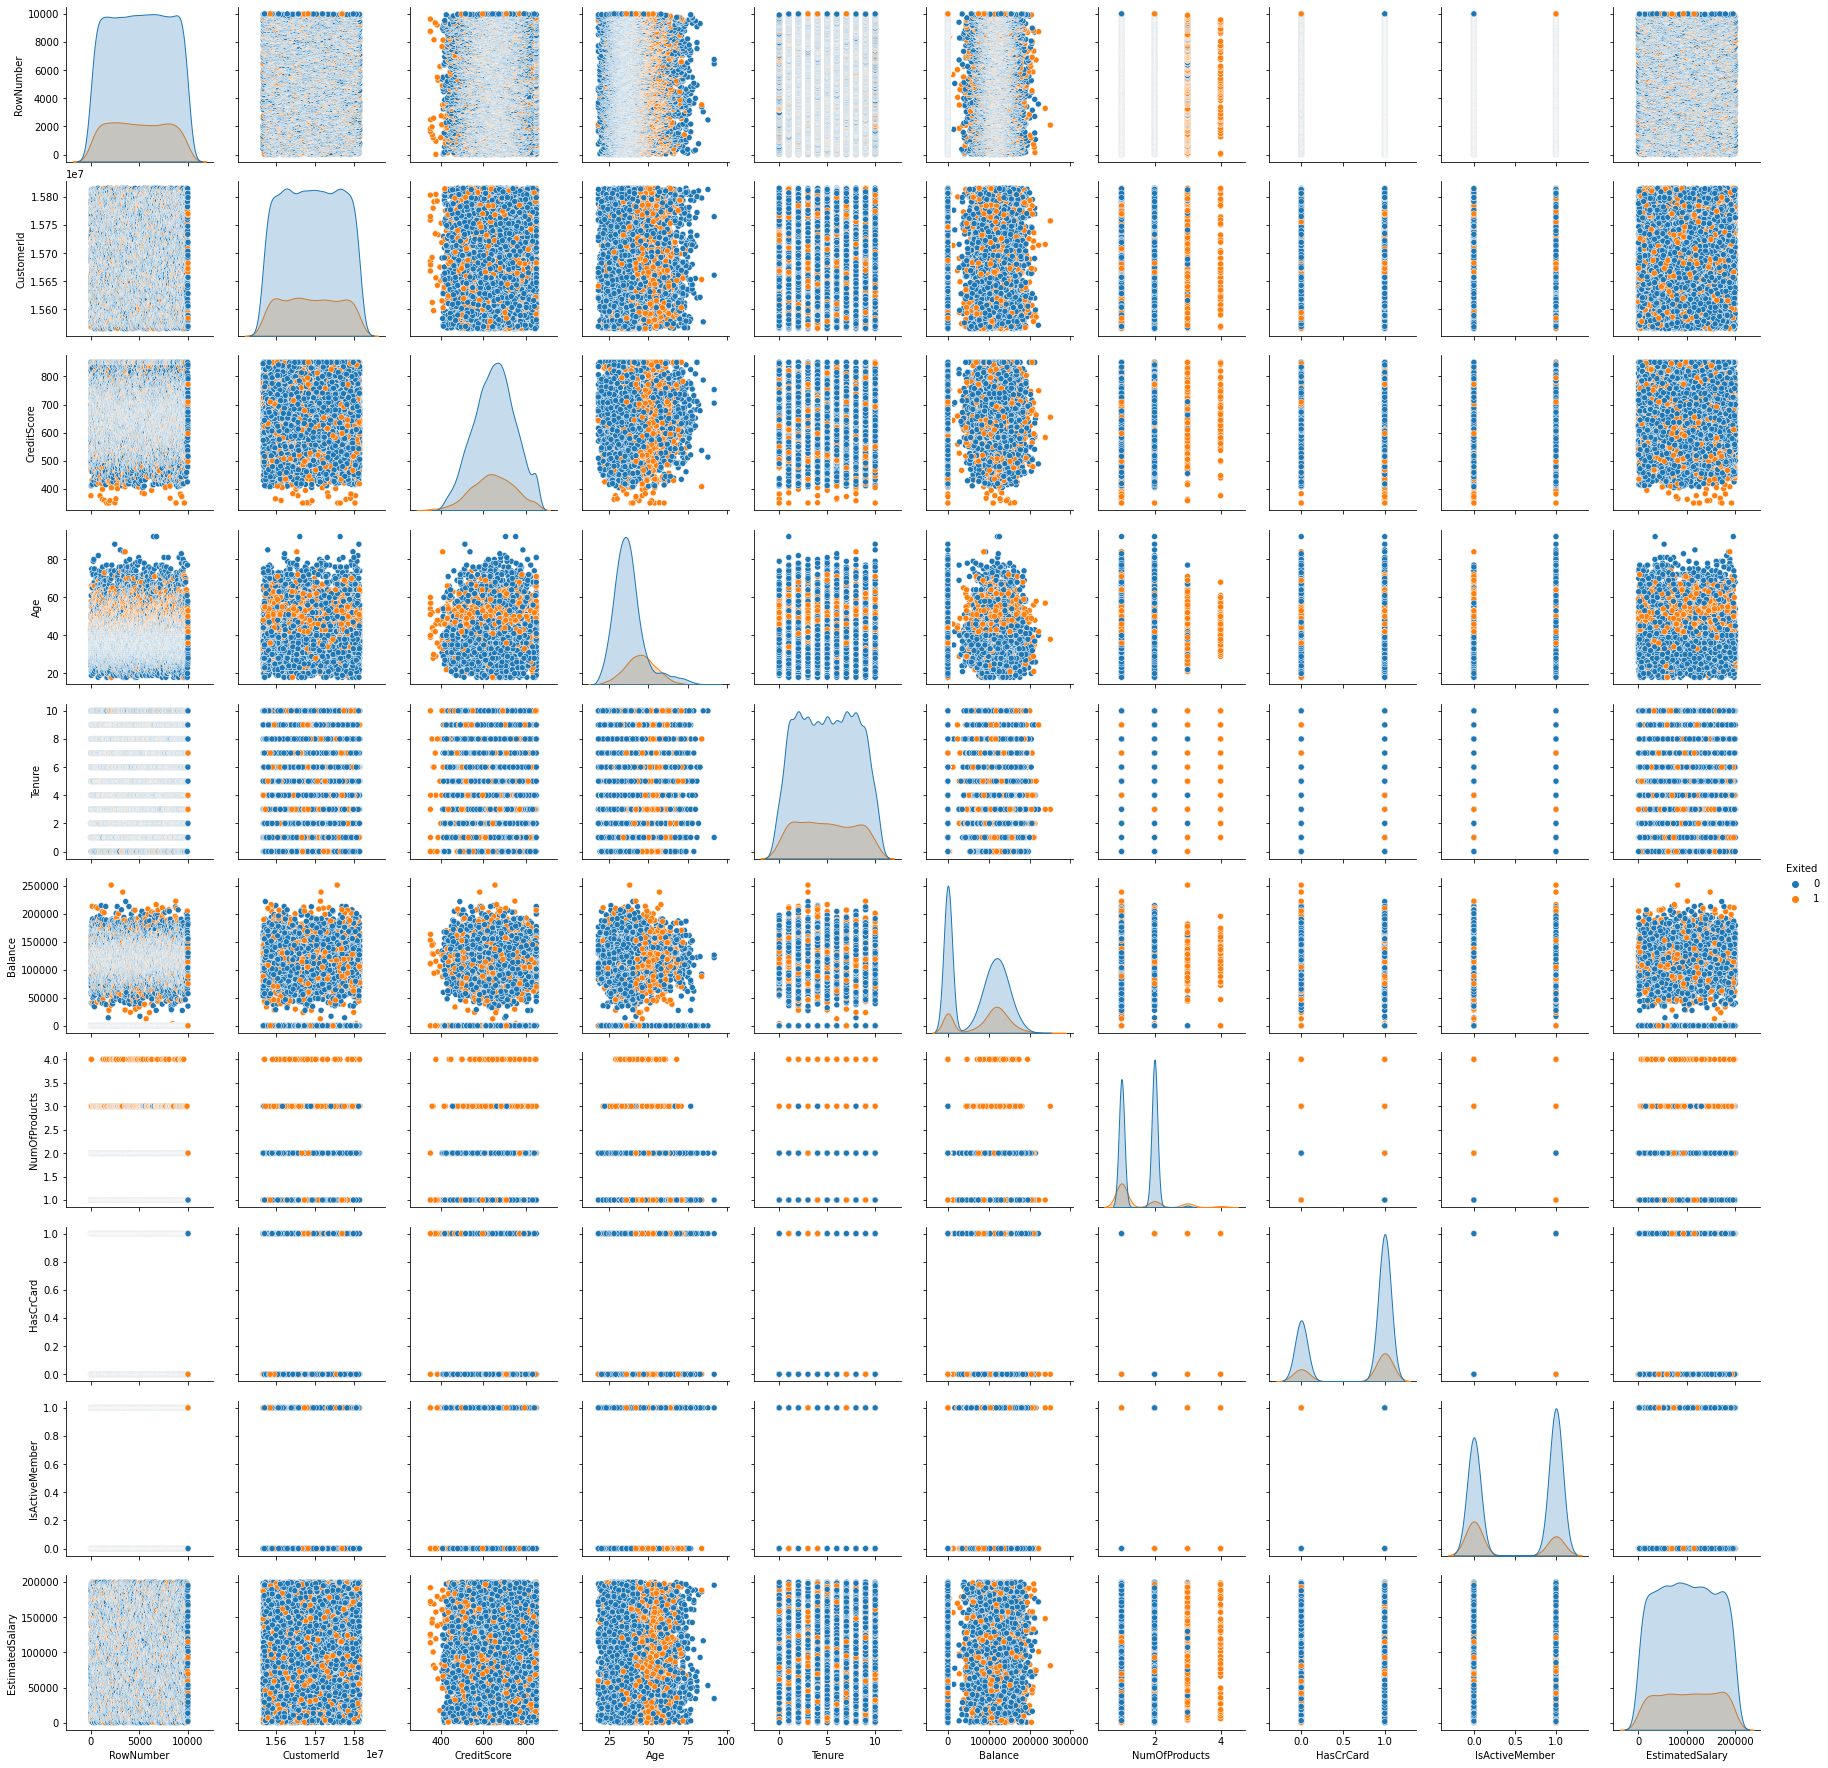

In [ ]:
sns.pairplot(data, hue='Exited');

На графиках не видно сколь-нибудь сильной корреляции между признаками, на данном этапе сохраним все признаки для последующей работы.

In [ ]:
data.duplicated().sum() # проверим данные на дубликаты

0

In [ ]:
data.describe() #проверим разброс данных при помощи метода describe

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


Критических отклонений медианных значений нет ни по одному из признаков, данные выглядят довольно реалистично. 

In [ ]:
data.info() # изучим общую информацию о датафрейме

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Всего 10000 строк и 14 колонок. Все типы данных выглядят адекватными, возможно только количество лет пользования клиента услугами банка можно привести к целочисленному значению ( `Tenure`). Также в этой колонке присутствуют пустые значения. Возможно они относятся к новым клиентам, проверим выборку по таким позициям. 

In [ ]:
data[data['Tenure'].isnull()] #изучим данные с пустыми значениями в колонке Tenure

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
30,31,15589475,Azikiwe,591,Spain,Female,39,NaN,0.00,3,1,0,140469.38,1
48,49,15766205,Yin,550,Germany,Male,38,NaN,103391.38,1,0,1,90878.13,0
51,52,15768193,Trevisani,585,Germany,Male,36,NaN,146050.97,2,0,0,86424.57,0
53,54,15702298,Parkhill,655,Germany,Male,41,NaN,125561.97,1,0,0,164040.94,1
60,61,15651280,Hunter,742,Germany,Male,35,NaN,136857.00,1,0,0,84509.57,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9944,9945,15703923,Cameron,744,Germany,Male,41,NaN,190409.34,2,1,1,138361.48,0
9956,9957,15707861,Nucci,520,France,Female,46,NaN,85216.61,1,1,0,117369.52,1
9964,9965,15642785,Douglas,479,France,Male,34,NaN,117593.48,2,0,0,113308.29,0
9985,9986,15586914,Nepean,659,France,Male,36,NaN,123841.49,2,1,0,96833.00,0


Наверняка CustomerID присваивался по порядку, а как видно из выборки, пропущенные значения в колонке Tenure могут относиться не только к новым клиентам с порядковыми номерами, начинающимися на 157, но и к старым клиентам - 155 и 156. Такие клиенты уже имеют стаж работы с банком до 10 лет. Видимо не будет верным решением заменить отсутствующие значения на нули.Заменим отсутсвующие значения в этой колонке на медианные, а тип данных на целочисленные значения.

In [ ]:
tenure_median = data['Tenure'].median()
data['Tenure'] = data['Tenure'].fillna(tenure_median).astype(int)
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


Проверим распределение значений после заполнения данных в столбце `Tenure`медианными.

In [ ]:
data['Tenure'].describe()

count    10000.00000
mean         4.99790
std          2.76001
min          0.00000
25%          3.00000
50%          5.00000
75%          7.00000
max         10.00000
Name: Tenure, dtype: float64

Основные показатели изменились незначительно после заполнения данных. Среднее значение практически не изменилось, медианное значение осталось прежним. Немного увеличилось стандартное отклонение: с 2.76 до 2.89 и 25% значений в этом столбце теперь содержат продолжительность пользования услугами 3 года, а не 2, как это было раньше.

Посмотрим как распределяются клиенты по странам.

In [ ]:
dg = data.groupby(['Geography'])['Exited'].agg(['count','sum'])
dg['exited_rate'] = dg['sum']/dg['count']*100
dg

,count,sum,exited_rate
Geography,,,
France,5014,810,16.154767
Germany,2509,814,32.443204
Spain,2477,413,16.673395


Больше всего клиентов банка проживают во Франции, но в Германии доля недовольных клиентов в 2 раза больше, чем в каждой из других стран.

Проверим как распределяются недовольные клиенты в зависимости от количества банковских продуктов, которыми они пользуются.

In [ ]:
dnop = data.groupby(['NumOfProducts'])['Exited'].agg(['count','sum'])
dnop['exited_rate'] = dnop['sum']/dnop['count']*100
dnop

,count,sum,exited_rate
NumOfProducts,,,
1,5084,1409,27.714398
2,4590,348,7.581699
3,266,220,82.706767
4,60,60,100.000000


Разбивка по количеству используемых продуктов показывает, что чаще всего уходят самые давние и активниые клиенты - 80% пользователей трех продуктов и 100%(!) пользователей четырех продуктов.

Данные по фамилиям клиентов, их ID и порядковым номерам в таблице нам не пригодятся для составления прогноза по уходу клиентов, поэтому удалим их из датасета, а также заменим категориальные значения в столбцах `Geography` и `Gender`в исходной таблице методом прямого кодирования (OHE). Разобьем признаки на тренировочную, валидационную и тестовые выборки из соотношения 60%:20%:20%. Преобразуем масштаб полученных данных методом стандартизации. В код добавим параметр stratify в train_test_split. Стратификацию проведем по целевому признаку `target`

In [ ]:
data = data.drop(['RowNumber', 'CustomerId', 'Surname'],axis=1)
data_ohe = pd.get_dummies(data, drop_first=True)
target = data_ohe['Exited']
features = data_ohe.drop(['Exited'] , axis=1)
features_1, features_test, target_1, target_test = train_test_split(
    features, target, test_size=0.2, random_state = 12345, stratify = target)
features_train, features_valid, target_train, target_valid = train_test_split(
    features_1, target_1, test_size=0.25, random_state = 12345, stratify = target_1)
numeric = ['CreditScore','Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard','IsActiveMember', 'EstimatedSalary']
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])
print(features_train.shape) #проверим объем полученных данных по каждой выборке
print (features_valid.shape)
print (features_test.shape)


(6000, 11)
(2000, 11)
(2000, 11)


## Исследование задачи

Определим как распределены положительное и отрицательное значение для целевого признака.

In [ ]:
print ('Доля ушедших из банка: {:.1%}'.format((target[target == 1].count()/len(target))))
print ('Доля оставшихся в банке: {:.1%}'.format(target[target == 0].count()/len(target)))

Доля ушедших из банка: 20.4%
Доля оставшихся в банке: 79.6%


Процент покинувших банк клиентов действительно довольно большой - пятая часть ушла. Поскольку есть большая разница между долями положительного и отрицательного значения целевого признака, данные можно считать несбалансированными. Обучим модель дерева решений не учитывая дисбаланс классов, как задано по условиям проекта.


Визуализируем дисбаланс данных целевого признака при помощи круговой диаграммы.


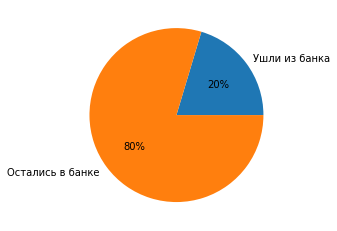

In [ ]:
labels = ['Ушли из банка', 'Остались в банке']
plt.pie([target[target == 1].count(),target[target == 0].count()], labels = labels, autopct='%.0f%%')
plt.show()

Подберем наилучшие параметры для дерева решений.

In [ ]:
for depth in range(1,10):
    model = DecisionTreeClassifier( random_state=12345,max_depth=depth)
    model.fit(features_train,target_train)
    predictions_valid = model.predict(features_valid)
    print("max_depth =", depth, ": ", end='')
    print ('F1-мера:', f1_score(target_valid,predictions_valid))

max_depth = 1 : F1-мера: 0.0
max_depth = 2 : F1-мера: 0.514792899408284
max_depth = 3 : F1-мера: 0.375
max_depth = 4 : F1-мера: 0.5168539325842697
max_depth = 5 : F1-мера: 0.46315789473684216
max_depth = 6 : F1-мера: 0.5382165605095541
max_depth = 7 : F1-мера: 0.5505443234836704
max_depth = 8 : F1-мера: 0.5816618911174785
max_depth = 9 : F1-мера: 0.5770308123249299


Наилучшее значение F1-меры достигается при глубине дерева равной  8 (0.581661). 
Проверим значения точности и полноты для модели с найденным параметром.

In [ ]:
model = DecisionTreeClassifier(max_depth=7,random_state=12345)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print ('Матрица ошибок:',confusion_matrix(target_valid,predicted_valid))
print ('Полнота:', recall_score(target_valid,predicted_valid))
print ('Точность:',precision_score(target_valid,predicted_valid))
print ('F1-мера:', f1_score(target_valid,predicted_valid))
# рассчитаем дополнительно AUC-ROC
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print(f'AUC_ROC: {auc_roc}')


Матрица ошибок: [[1534   59]
 [ 230  177]]
Полнота: 0.4348894348894349
Точность: 0.75
F1-мера: 0.5505443234836704
AUC_ROC: 0.8310575598711192


Выше в коде добавлен расчет показателя AUC-ROC. Значение 0.8184, что значительно выше AUC-ROC случайной модели.

Модель одинаково часто видит FN и TP классы. Значение полноты оставляет желать лучшего, она далека о единицы: модель лишь в половине случае правильно прогнозирует положительное значение целевого признака. Значение точности не так мало, наша модель находит не слишком много ложноположительных значений.F1-мера также слишком мала, по условиям задачи нам необходимо довести её минимум до 0.59.

Построим модель логистической регрессии для несбалансированных данных.

In [ ]:
model = LogisticRegression(random_state = 12345, solver ='lbfgs', max_iter=1000)
model.fit(features_train,target_train)
predicted_valid = model.predict(features_valid)
print ('F1-мера:', f1_score(target_valid,predicted_valid)) 
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print(f'AUC_ROC: {auc_roc}')

F1-мера: 0.3214953271028037
AUC_ROC: 0.7874854824007367


Логистическая регрессия показала наименьшее средннее гармоническое для полноты и точности.

<div class="alert alert-info">
В код добавил расчет показателя AUC-ROC, его значение для рассматриваемой модели также совсем небольшое.
</div>

## Борьба с дисбалансом

Выберем лучшую модель для прогнозирования. Придадим объектам редкого класса больший вес, указав в параметрах моделей class_weight = 'balanced'.

<div class="alert alert-info">
В коды добавил расчет показателя AUC-ROC.
</div>

In [ ]:
for depth in range(1,10):
    model = DecisionTreeClassifier( random_state=12345,max_depth=depth, class_weight ='balanced')
    model.fit(features_train,target_train)
    predictions_valid = model.predict(features_valid)
    probabilities_valid = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
    print("max_depth =", depth, ": ", end='')
    print ('F1-мера:', f1_score(target_valid,predictions_valid),';',f'AUC_ROC: {auc_roc}')    
    

max_depth = 1 : F1-мера: 0.49916527545909845 ; AUC_ROC: 0.7128962552691366
max_depth = 2 : F1-мера: 0.5074135090609556 ; AUC_ROC: 0.7538000249864657
max_depth = 3 : F1-мера: 0.5336538461538461 ; AUC_ROC: 0.8064212132008742
max_depth = 4 : F1-мера: 0.5422594142259414 ; AUC_ROC: 0.8254055287953593
max_depth = 5 : F1-мера: 0.5606190885640585 ; AUC_ROC: 0.8373936340038034
max_depth = 6 : F1-мера: 0.5747330960854092 ; AUC_ROC: 0.8353337929609115
max_depth = 7 : F1-мера: 0.5691056910569106 ; AUC_ROC: 0.8157140191038496
max_depth = 8 : F1-мера: 0.5548504079782411 ; AUC_ROC: 0.7963595336476692
max_depth = 9 : F1-мера: 0.5293005671077505 ; AUC_ROC: 0.7722815265188148


Наилучшее соотношение полноты и точности достигается при глубине дерева равной 6. Сбалансированность данных помогла незначительно повысить значение F1- меры (0.5505 vs 0.5747) **также выросло значение AUC-ROC ( c 0.831057 до 0.835333)** 

Следующий алгоритм обработки данных, который мы рассмотрим для целей обучения модели - логистическая регрессия.

In [ ]:
model = LogisticRegression(random_state = 12345, solver ='lbfgs', max_iter=1000,class_weight='balanced')
model.fit(features_train,target_train)
predicted_valid = model.predict(features_valid)
print ('F1-мера:', f1_score(target_valid,predicted_valid)) 
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print(f'AUC_ROC: {auc_roc}')

F1-мера: 0.5108601216333623
AUC_ROC: 0.7917516900567748


Точность и полнота модели значительно улучшились на сбалансированных данных. Но значение F1 **и AUC-ROC** метрики слишком мало, логистическую регрессию убираем из дальнейшего рассмотрения.

Подберем лучшие параметры для случайного леса.

In [ ]:
clf = RandomForestClassifier(random_state=12345)
parametrs = { 'n_estimators': range (10, 51, 10),
              'max_depth': range (1,13, 2),
              'min_samples_leaf': range (1,8),
              'min_samples_split': range (2,10,2) }
grid = GridSearchCV(clf, parametrs, cv=5, scoring = 'f1') #запускаем обучение и смотрим какие наилучшие параметры получим при помощи инструмента GridSearchCV
grid.fit(features_train, target_train)
grid.best_params_

{'max_depth': 11,
 'min_samples_leaf': 2,
 'min_samples_split': 8,
 'n_estimators': 40}

Обучим модель, задав найденные параметры и определим какой показатель F1 будет получен при их использовании.

In [ ]:
model = RandomForestClassifier(random_state=12345, max_depth = 11, 
                               min_samples_leaf = 2, min_samples_split = 8, 
                               n_estimators = 40, class_weight='balanced') 
model.fit(features_train,target_train)
predicted_valid = model.predict(features_valid)
print ('F1-мера:', f1_score(target_valid,predicted_valid)) 
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print(f'AUC_ROC: {auc_roc}')

F1-мера: 0.6326276463262764
AUC_ROC: 0.8639486944571689


Значение F1 меры  уже достаточно - по условиям задания мы должны добиться показателя минимум 0.59
Для еще большего улучшения метрики воспользуемся методом увеличения выборки объектов редкого класса. **Значение AUC-ROC самое высокое среди рассматриваемых моделей.**

In [ ]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)
best_model = RandomForestClassifier(random_state=12345, max_depth = 11, 
                               min_samples_leaf = 1, min_samples_split = 8, 
                               n_estimators = 30, class_weight='balanced')
best_model.fit(features_upsampled, target_upsampled)
predicted_valid = best_model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.6247191011235955


In [ ]:
print ('Доля ушедших из банка(после увеличения доли этих объектов в выборке): {:.1%}'.format((target_upsampled[target == 1].count()/len(target))))
print ('Доля оставшихся в банке(после увеличения доли ушедших из банка в выборке): {:.1%}'.format(target_upsampled[target == 0].count()/len(target)))

Доля ушедших из банка(после увеличения доли этих объектов в выборке): 48.9%
Доля оставшихся в банке(после увеличения доли ушедших из банка в выборке): 47.8%


Мы добились заданного значения метрики F1, используем эту модель для тестирования.

<div class="alert alert-info">
Для наглядности внесем полученные метрики по трем моделям в сводную таблицу.
</div>

In [ ]:
d = {'Алгоритм обучения': ['DecisionTreeClassifier', 'RandomForestClassifier', 
    'LogisticRegression'], 'F1': [0.5747, 0.6287, 0.5108], 'AUC-ROC':[0.8353,0.8633,0.7917]}
df = pd.DataFrame(data=d).set_index('Алгоритм обучения')
df

,F1,AUC-ROC
Алгоритм обучения,,
DecisionTreeClassifier,0.5747,0.8353
RandomForestClassifier,0.6287,0.8633
LogisticRegression,0.5108,0.7917


<div class="alert alert-info">
RandomForestClassifier вне конкуренции по обеим метрикам.
</div>

## Тестирование модели

Проверим метрики выбранной модели на тестовых данных.

In [ ]:
best_model.fit(features_upsampled, target_upsampled)
predicted_test = best_model.predict(features_test)
print("F1:", f1_score(target_test, predicted_test))

F1: 0.6136363636363636


На тестовой выборке мы достигли достаточного показателя метрики F1. 

Чтобы выявить, как сильно наша модель отличается от случайной, посчитаем площадь под ROC-кривой — AUC-ROC 

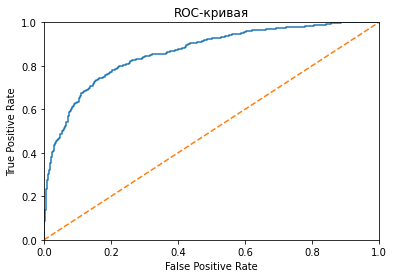

0.8626083710829473


In [ ]:
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

auc_roc = roc_auc_score(target_test, probabilities_one_test)
print(auc_roc)

Значение AUC-ROC хотя и далеко еще от единицы, но уже значительно выше аналогичного показателя для случайной модели (0.5). 
Что позволяет утверждать, что с использованием найденной модели мы с большой долей вероятности сможем спрогнозировать останется ли клиент в банке, исходя из заданных параметров, или уйдет из него.

В ходе выполнения проекта мы изучили данные по клиентам банка, исследовали их основные характеристики и подготовили данные к дальнейшему выбору модели обучения. 
На основании исследования баланса классов мы пришли к выводу о необходимости устранения дисбаланса, эту задачу удалось выполнить путем увеличения количества строк положительного класса и добавленния аргумента `class_weight` в алгоритмы обучения моделей.
На валидационной выборке были сравнены значения F1 и AUC-ROC метрик для каждой из трех рассматриваемых моделей ( DecisionTreeClasifier, RandomForestClassifier и LogisticRegresdsion) и выбрана модель с наилучшими метриками (RandomForestClassifier).
Выбранная модель показала на тестовой выборке результаты, достаточные для решения поставленной задачи, можем рекомендовать её для использования в прогнозировании отказов клиентов банка от обслуживания и для борьбы с их уходом из банка.